In [15]:
# Import TensorFlow and other necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [20]:
dataset_url = "data/training/"
data_dir = pathlib.Path(dataset_url)

image_count = len(list(data_dir.glob('*/*.jpg'))) + \
    len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

22060


In [21]:
# Image Loader Params
batch_size = 64
img_height = 120
img_width = 128

print(data_dir)

# Train Split at 80%
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Validation of the data at 80%
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


data/training
Found 22060 files belonging to 2 classes.
Using 17648 files for training.
Found 22060 files belonging to 2 classes.
Using 4412 files for validation.


['humans', 'nonhumans']


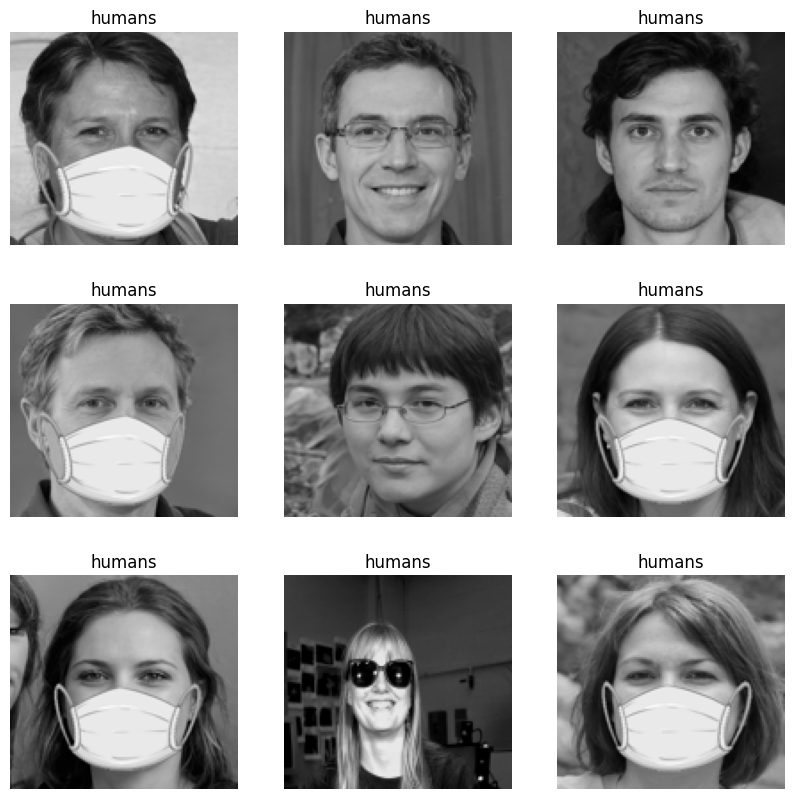

In [22]:
# Classification of names - each image type in its own dir
class_names = train_ds.class_names
print(class_names)

# Visualize the images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-11-02 21:14:47.988237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2022-11-02 21:14:48.033289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2022-11-02 21:14:48.064892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2022-11-02 21:14:48.087539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2022-11-02 21:14:48.133438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2022-11-02 21:14:48.134330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2022-11-02

0.003921569 0.9294118


2022-11-02 21:14:51.005850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


In [24]:
# Create basic Keras Model

# The Keras Sequential model consists of three convolution blocks(tf.keras.layers.Conv2D)
# with a max pooling layer(tf.keras.layers.MaxPooling2D) in each of them.
#
# There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that
# is activated by a ReLU activation function ('relu').
#
# This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Compile the model

# For this tutorial, choose the tf.keras.optimizers.Adam optimizer and
# tf.keras.losses.SparseCategoricalCrossentropy loss function.
#
# To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

# Show the Model Summary - need to look into what this means
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 120, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 32, 64)        1

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

In [ ]:
# Visualize the Training Results in Plot Forms
def visualization_report(history, epochs=10):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


visualization_report(history, epochs)


In [ ]:
sunflower_path = "data/predictions/Red_sunflower"
rose_path = "data/predictions/rose.jpeg"
tulip_path = "data/predictions/tulips.jpeg"

paths = [sunflower_path, rose_path, tulip_path]

for p in paths:
    img = tf.keras.utils.load_img(
        p, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
